In [1]:
!nvidia-smi

Thu May 19 02:38:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install modules

In [3]:
pip install datasets

     |████████████████████████████████| 342 kB 18.0 MB/s 
     |████████████████████████████████| 136 kB 71.5 MB/s 
     |████████████████████████████████| 1.1 MB 65.6 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 212 kB 67.5 MB/s 
     |████████████████████████████████| 127 kB 75.0 MB/s 
     |████████████████████████████████| 271 kB 39.7 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 144 kB 76.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
pip install transformers

     |████████████████████████████████| 4.2 MB 30.6 MB/s 
     |████████████████████████████████| 596 kB 60.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from datasets import load_dataset

dataset = load_dataset("xnli",language='vi')

Using custom data configuration default-language=vi


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/default-language=vi/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

In [ ]:
import pandas as pd

In [ ]:
train=pd.DataFrame(dataset['train'])

In [ ]:
train=train.sample(frac=1)

In [ ]:
len(train)//5

78540

In [ ]:
for i in range(5):
  train_i=train.iloc[i*78540:(i+1)*78540]
  train_i.to_csv(f'/content/drive/MyDrive/vi-nli/raw_dataset/train_{i}.csv',index=False)

In [ ]:
valid=pd.DataFrame(dataset['validation'])

In [ ]:
test=pd.DataFrame(dataset['test'])

In [ ]:
valid.to_csv("/content/drive/MyDrive/vi-nli/raw_dataset/valid.csv",index=False)

In [ ]:
test.to_csv("/content/drive/MyDrive/vi-nli/raw_dataset/test.csv",index=False)

#Import modules

In [1]:
import pandas as pd
import re
import string
from transformers import AutoTokenizer,AutoConfig,AutoModelForSequenceClassification,get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from os.path import join
import os
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
name='xlm-roberta-base'
max_length=256
index=1

root='/content/drive/MyDrive/vi-nli'
preprocessed_data=join(root,"preprocessed_data")
models=join(root,'models')
model_name=join(models,f'{name}-{max_length}')

In [4]:
os.makedirs(preprocessed_data, exist_ok=True)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(name)

#Load dataset

In [6]:
train=pd.read_csv(f'/content/drive/MyDrive/vi-nli/raw_dataset/train_{index}.csv')

In [7]:
train

,premise,hypothesis,label
0,Hum đó là thú vị,Điều đó rất thú vị .,1
1,Lao động lao động để cài đặt cũng được cung cấp .,Vật liệu ít tốn kém hơn là lao động lao động .,1
2,Rất nhiều công việc làm việc của ngày hôm nay ...,Tất cả các trang trại đều được sở hữu bởi gia ...,1
3,Có thể anh là người hữu dụng và họ có một chút...,"Nơi này không có quy tắc chính thức , và họ bi...",0
4,Nó được đề xuất để cung cấp một preconditioned...,"Một culligana , continentala , hoặc hệ thống t...",0
...,...,...,...
78535,Um điều bất ngờ tôi thực sự là Israel đang ngồ...,Sự kiên trì của người israel vẫn còn ở đó bao ...,0
78536,"Ngài Chủ tịch , việc này đã kết thúc lời tuyên...",Lời tuyên bố của tôi đã được đọc rất kỹ và đượ...,1
78537,"Trong cuộc chiến tranh lạnh , tự do bị loại bỏ...",Liên xô sẽ tiến hành đầy đủ chiến tranh nếu sự...,1
78538,Với tư cách là hàng triệu người đàn ông trên w...,Việc làm cho nguồn tài nguyên đã ngạc nhiên mộ...,1


In [8]:
valid=pd.read_csv("/content/drive/MyDrive/vi-nli/raw_dataset/valid.csv")

##Preprocessing

In [9]:
punctuations=list(string.punctuation)

In [10]:
def normalizer(text):

  def remove_meaningless_token(s):
    return re.sub(r'\b(jeez|yeah|uhhuh|uh|oh|huh)\b',' ',s)
  def uncased(s):
    return s.lower()

  def fix_whitespaces(s):
    return re.sub(r'\s+',' ',s)

  def remove_punctuations(s):
    chs=[]
    for ch in s:
      if ch not in punctuations:
        chs.append(ch)
      else:
        chs.append(" ")
    return "".join(chs)

  return fix_whitespaces(remove_meaningless_token(uncased(remove_punctuations(text)))).strip()

In [11]:
train['clean_premise']=train['premise'].map(normalizer)

In [12]:
valid['clean_premise']=valid['premise'].map(normalizer)

In [13]:
train['clean_hypothesis']=train['hypothesis'].map(normalizer)

In [14]:
valid['clean_hypothesis']=valid['hypothesis'].map(normalizer)

In [15]:
def seperate_sentence(s):
  return tokenizer.tokenize(s)

In [16]:
def get_seq_len(s):
  tokens=seperate_sentence(s)
  return len(tokens)

In [17]:
train['premise_seq_len']=train['clean_premise'].map(get_seq_len)
train['hypothesis_seq_len']=train['clean_hypothesis'].map(get_seq_len)

In [18]:
valid['premise_seq_len']=valid['clean_premise'].map(get_seq_len)
valid['hypothesis_seq_len']=valid['clean_hypothesis'].map(get_seq_len)

In [19]:
def seq_len_visualizer(x,y):
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(20,20))
  ax.bar(x,y)
  fig.show()

In [20]:
max(train['premise_seq_len'].unique()),max(train['hypothesis_seq_len'].unique())

(440, 85)

In [21]:
max(valid['premise_seq_len'].unique()),max(valid['hypothesis_seq_len'].unique())

(77, 37)

In [22]:
min(train['premise_seq_len'].unique()),min(train['hypothesis_seq_len'].unique())

(0, 0)

In [23]:
min(valid['premise_seq_len'].unique()),min(valid['hypothesis_seq_len'].unique())

(4, 2)

In [24]:
train=train[~(train['premise_seq_len']==0)]

In [25]:
train=train[~(train['hypothesis_seq_len']==0)]

In [26]:
valid[(valid['premise_seq_len']==0)]

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len


In [27]:
valid[(valid['hypothesis_seq_len']==0)]

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len


In [28]:
samples1=train['clean_premise'].tolist()[:100]
samples2=train['clean_hypothesis'].tolist()[:100]
for i in range(100):
  print(samples1[i])
  print(samples2[i])
  print('\n')
  

hum đó là thú vị
điều đó rất thú vị


lao động lao động để cài đặt cũng được cung cấp
vật liệu ít tốn kém hơn là lao động lao động


rất nhiều công việc làm việc của ngày hôm nay sẽ vẫn được nhận ra bởi những chủ sở hữu trang trại đầu tiên
tất cả các trang trại đều được sở hữu bởi gia đình của những chủ sở hữu trang trại đầu tiên


có thể anh là người hữu dụng và họ có một chút gợi ý để bắt đầu một sự ồn ào chỉ để cho thấy không có luật pháp nào phù hợp ở đấy
nơi này không có quy tắc chính thức và họ biết điều đó


nó được đề xuất để cung cấp một preconditioned deionized nguồn cấp nước bằng cách sử dụng một culligana continentala hoặc hệ thống tương đương trước hệ thống milliporea để kéo dài cuộc sống của các hộp milliporea xem phần 5 cơ sở thiết bị và cung cấp không
một culligana continentala hoặc hệ thống tương tự có thể kéo dài cuộc sống của milliporea đạn


cung điện đã được khôi phục tuyệt vời kể từ khi chiến tranh thế giới tôi với sự giúp đỡ của những đóng góp riêng đặc biệt nhất

There are some meaningless tokens such as à, ừ, ... -> need to remove them

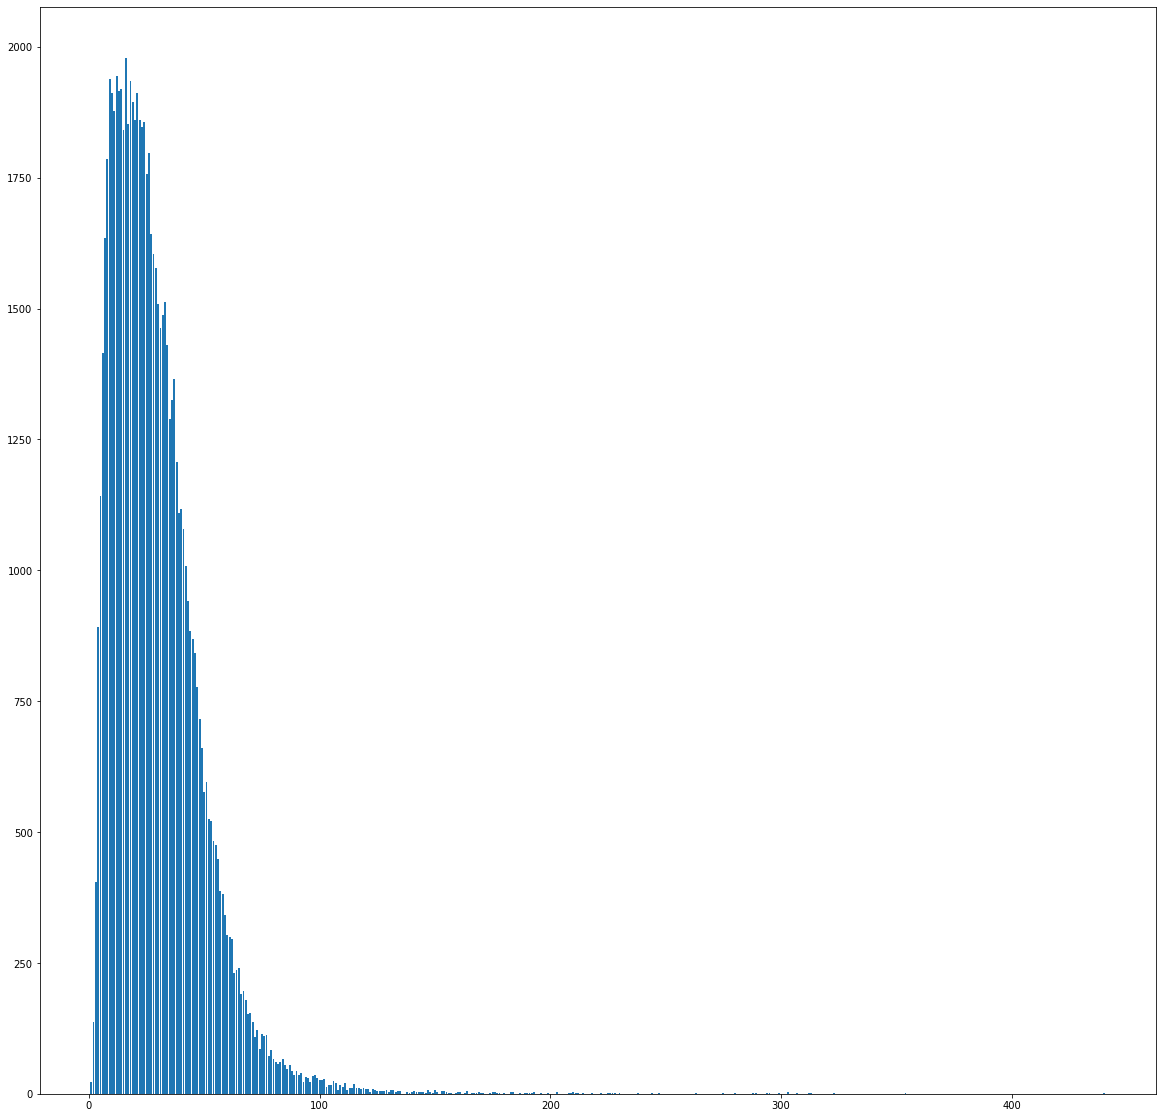

In [29]:
dict_occurs=train['premise_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

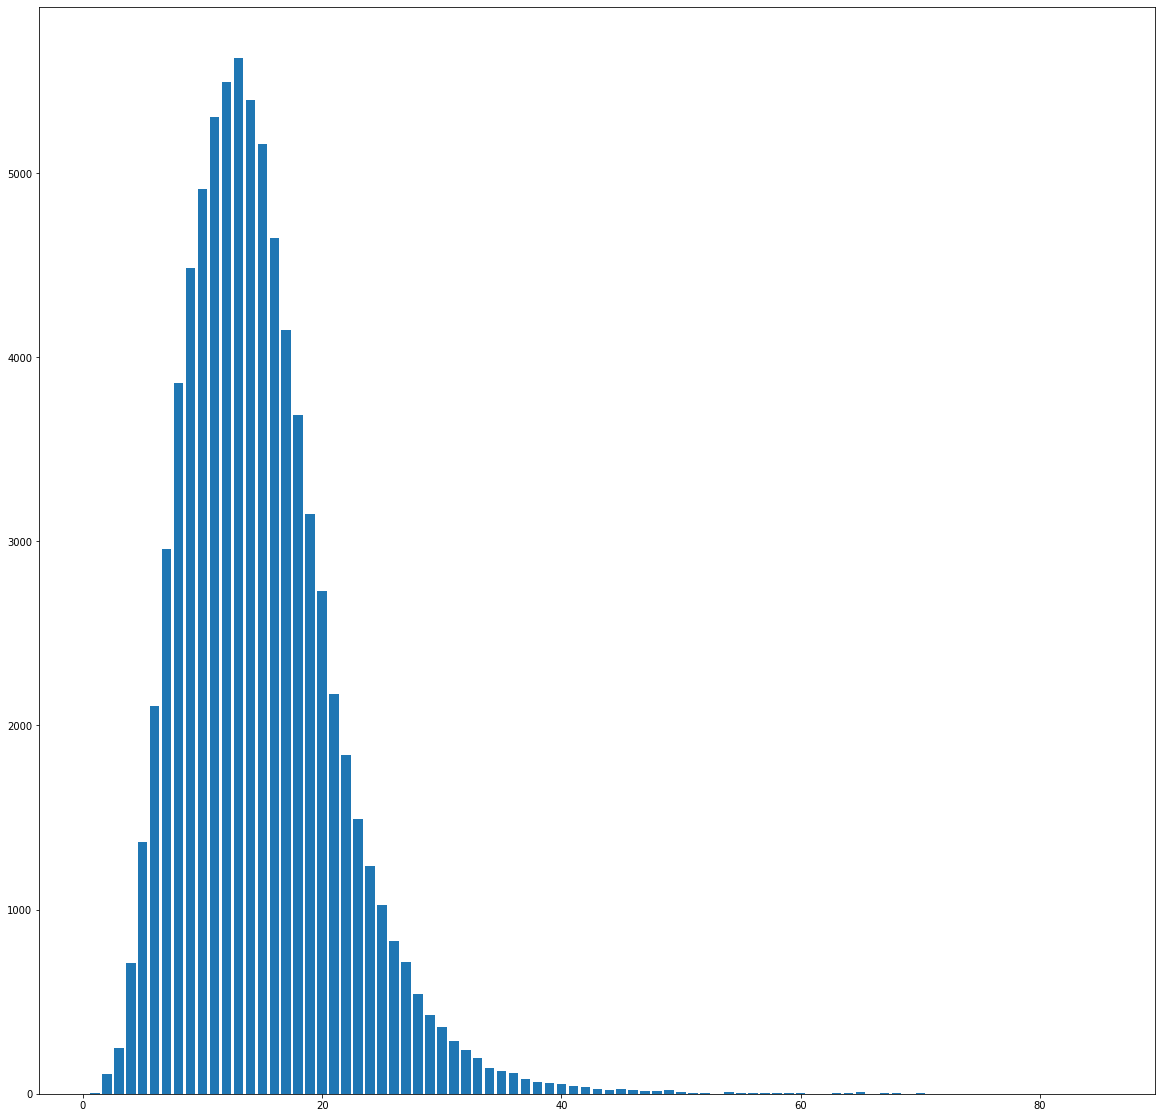

In [30]:
dict_occurs=train['hypothesis_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

In [31]:
train['total_seq_len']=train['premise_seq_len']+train['hypothesis_seq_len']

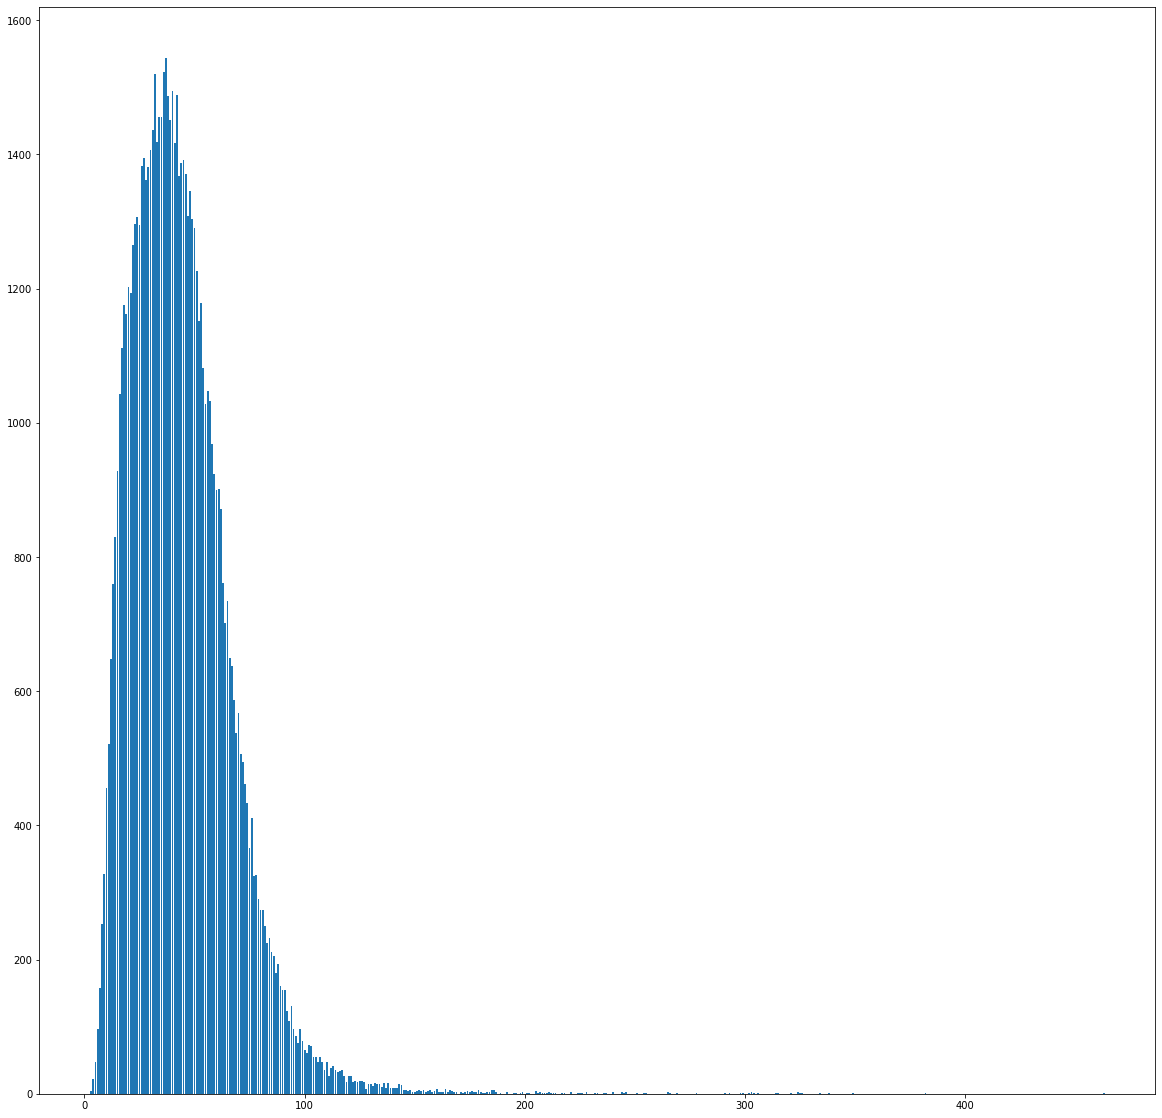

In [32]:
dict_occurs=train['total_seq_len'].value_counts().to_dict()
x,y=list(dict_occurs.keys()),list(dict_occurs.values())
seq_len_visualizer(x,y)

assign max length 256

In [33]:
train.value_counts(['label'])

label
1        26179
0        26107
2        26102
dtype: int64

In [34]:
valid.value_counts(['label'])

label
0        830
1        830
2        830
dtype: int64

In [35]:
train.to_csv(join(preprocessed_data,f'train_{index}.csv'),index=False)
valid.to_csv(join(preprocessed_data,'valid.csv'),index=False)

In [36]:
train

,premise,hypothesis,label,clean_premise,clean_hypothesis,premise_seq_len,hypothesis_seq_len,total_seq_len
0,Hum đó là thú vị,Điều đó rất thú vị .,1,hum đó là thú vị,điều đó rất thú vị,5,5,10
1,Lao động lao động để cài đặt cũng được cung cấp .,Vật liệu ít tốn kém hơn là lao động lao động .,1,lao động lao động để cài đặt cũng được cung cấp,vật liệu ít tốn kém hơn là lao động lao động,13,14,27
2,Rất nhiều công việc làm việc của ngày hôm nay ...,Tất cả các trang trại đều được sở hữu bởi gia ...,1,rất nhiều công việc làm việc của ngày hôm nay ...,tất cả các trang trại đều được sở hữu bởi gia ...,24,21,45
3,Có thể anh là người hữu dụng và họ có một chút...,"Nơi này không có quy tắc chính thức , và họ bi...",0,có thể anh là người hữu dụng và họ có một chút...,nơi này không có quy tắc chính thức và họ biết...,36,13,49
4,Nó được đề xuất để cung cấp một preconditioned...,"Một culligana , continentala , hoặc hệ thống t...",0,nó được đề xuất để cung cấp một preconditioned...,một culligana continentala hoặc hệ thống tương...,60,22,82
...,...,...,...,...,...,...,...,...
78535,Um điều bất ngờ tôi thực sự là Israel đang ngồ...,Sự kiên trì của người israel vẫn còn ở đó bao ...,0,um điều bất ngờ tôi thực sự là israel đang ngồ...,sự kiên trì của người israel vẫn còn ở đó bao ...,76,21,97
78536,"Ngài Chủ tịch , việc này đã kết thúc lời tuyên...",Lời tuyên bố của tôi đã được đọc rất kỹ và đượ...,1,ngài chủ tịch việc này đã kết thúc lời tuyên b...,lời tuyên bố của tôi đã được đọc rất kỹ và đượ...,15,19,34
78537,"Trong cuộc chiến tranh lạnh , tự do bị loại bỏ...",Liên xô sẽ tiến hành đầy đủ chiến tranh nếu sự...,1,trong cuộc chiến tranh lạnh tự do bị loại bỏ s...,liên xô sẽ tiến hành đầy đủ chiến tranh nếu sự...,49,25,74
78538,Với tư cách là hàng triệu người đàn ông trên w...,Việc làm cho nguồn tài nguyên đã ngạc nhiên mộ...,1,với tư cách là hàng triệu người đàn ông trên w...,việc làm cho nguồn tài nguyên đã ngạc nhiên mộ...,28,18,46


##Create inputs for bert models

In [6]:
train=pd.read_csv(join(preprocessed_data,f'train_{index}.csv'))
valid=pd.read_csv(join(preprocessed_data,'valid.csv'))

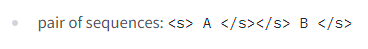

In [7]:
class ClassificationDataset(Dataset):
    def __init__(self, input_ids, attention_mask,labels,device,token_type_ids=None):
        self.labels = labels
        self.input_ids=input_ids
        self.attention_mask=attention_mask
        self.token_type_ids=token_type_ids
        self.device=device
        
    def __len__(self):
            return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        sample = {"inputs":{"input_ids": input_ids.to(self.device),'attention_mask':attention_mask.to(self.device)}, "labels": label.to(self.device)}
        if self.token_type_ids!=None:
          sample['inputs'].update({'token_type_ids':self.token_type_ids[idx].to(self.device)})
        return sample

In [8]:
train_batch_size=32
num_training_samples=len(train)
num_training_batches=int((num_training_samples/train_batch_size)+0.5)

In [9]:
valid_batch_size=16
num_valid_samples=len(valid)
num_valid_batches=int((num_valid_samples/valid_batch_size)+0.5)

In [10]:
return_tensors='pt'

In [11]:
labels=train['label'].unique().tolist()
labels

[1, 0, 2]

In [12]:
def create_dataloader(tokenizer,premises,hypothesises,labels,max_length,batch_size,padding=True,truncation=True,return_tensors='pt',device='cpu',drop_last=False):
  x=tokenizer(premises ,hypothesises,padding=padding,truncation=truncation,max_length=max_length,return_tensors=return_tensors)
  y=torch.Tensor(labels).to(torch.long)
  dataset={i:x[i] for i in x}
  dataset.update({"labels":y})
  dataset=ClassificationDataset(**dataset,device=device)
  dataset=DataLoader(dataset,batch_size=batch_size,drop_last=drop_last,shuffle=True)
  return dataset

In [13]:
train_premises=train['clean_premise'].tolist()#[:30000]
train_hypothesises=train['clean_hypothesis'].tolist()#[:30000]
train_labels=train['label'].tolist()#[:30000]

In [14]:
train_dataloader=create_dataloader(tokenizer,train_premises,train_hypothesises,train_labels,max_length=max_length,return_tensors=return_tensors,device=device,drop_last=False,batch_size=train_batch_size)

In [15]:
valid_premises=valid['clean_premise'].tolist()
valid_hypothesises=valid['clean_hypothesis'].tolist()
valid_labels=valid['label'].tolist()

In [16]:
valid_dataloader=create_dataloader(tokenizer,valid_premises,valid_hypothesises,valid_labels,max_length=max_length,return_tensors=return_tensors,device=device,drop_last=False,batch_size=valid_batch_size)

In [17]:
for i in train_dataloader:
  print(i['inputs']['input_ids'][0])
  print(i['inputs']['attention_mask'][0])
  break

tensor([    0,  2259,  1408, 18049, 10587,     2,     2,  2259,  1408, 18049,
         5472, 10587,  2275,  5179,  4600,  6348,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

#Trainer

In [18]:
epochs=30
num_training_steps=epochs * len(train_dataloader)
num_warmup_steps=500
init_lr=1e-5
eps =1e-8

In [19]:
num_training_steps,num_warmup_steps

(73500, 500)

In [20]:
num_labels=len(labels)
num_labels

3

In [21]:
classifier_dropout=0.1

In [22]:
config=AutoConfig.from_pretrained(name)
config.classifier_dropout=classifier_dropout
config.num_labels=num_labels
config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": 0.1,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [23]:
model_index=join(model_name,f'model_{str(index)}')

In [24]:
config.save_pretrained(model_index)

In [25]:
model=AutoModelForSequenceClassification.from_pretrained(name,config=config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [26]:
optimizer=torch.optim.AdamW(model.parameters(),lr=init_lr,weight_decay =0.01,eps=eps)

In [27]:
#load pretrain from previous model

checkpoint = torch.load(f'/content/drive/MyDrive/vi-nli/models/xlm-roberta-base-256/model_{str(index-1)}/ckpt2.pt',map_location=device)

In [28]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
del checkpoint

In [30]:
lr_scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps,)

In [31]:
def save_model(epoch,model,optimizer,training_loss,valid_loss,path,step=None):
  torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'training_loss': training_loss,
          'valid_loss': valid_loss,
          'step':step
          }, join(path,f'ckpt{epoch}.pt'))

In [32]:
def run_train(optimizer,dataloader,lr_scheduler):
  model.train(True)
  loop = tqdm(dataloader)
  loss=0
  for batch in dataloader:
    # model.zero_grad(set_to_none=True)
    optimizer.zero_grad()
    inputs=batch['inputs']
    inputs.update({"labels":batch['labels']})
    outputs=model(**inputs)
    # _loss = loss_fn(logits.view(-1, num_labels), batch['labels'].view(-1))
    outputs.loss.backward()

    loss+=outputs.loss.item()
    optimizer.step()
    lr_scheduler.step()
    loop.set_postfix({f'train_loss_per_batch':outputs.loss.item()})
    loop.update()      
    
  return loss/len(dataloader)

In [33]:
def run_valid(dataloader):
  model.eval()
  loss=0
  with torch.no_grad():
    for batch in dataloader:
      inputs=batch['inputs']
      inputs.update({"labels":batch['labels']})
      outputs=model(**inputs)

      # _loss = loss_fn(logits.view(-1, num_labels), batch['labels'].view(-1))

      loss+=outputs.loss.item()

  return loss/len(dataloader)

In [ ]:
train_loss_per_step=[]
valid_loss_per_step=[]
min_loss=np.inf
count_stopping=np.inf
for epoch in range(1,epochs):
  train_loss=run_train(optimizer,train_dataloader,lr_scheduler)
  valid_loss=run_valid(valid_dataloader)

  train_loss_per_step.append(train_loss)
  valid_loss_per_step.append(valid_loss)
  
  print(f'epoch: {epoch} train_loss: {train_loss} valid_loss: {valid_loss}')
  if valid_loss<min_loss:
    min_loss=valid_loss
    save_model(epoch,model,optimizer,train_loss,valid_loss,model_index)
    count_stopping=0
  else:
    count_stopping+=1
  
  if count_stopping>5:
    break


  0%|          | 0/2450 [00:00<?, ?it/s]

#Inference

In [37]:
import pandas as pd
test=pd.read_csv('/content/drive/MyDrive/vi-nli/raw_dataset/test.csv')
test  

,premise,hypothesis,label
0,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",Tôi đã không nói chuyện với anh ta nữa.,2
1,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",Tôi buồn tới mức tôi lại bắt đầu nói chuyện lạ...,0
2,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",Chúng tôi có buổi nói chuyện tuyệt vời.,1
3,"Và tôi nghĩ đó là một đặc ân, và nó vẫn còn, n...",Tôi không nhận ra rằng tôi không phải là người...,1
4,"Và tôi nghĩ đó là một đặc ân, và nó vẫn còn, n...",Tôi có ấn tượng là tôi là người duy nhất có số...,0
...,...,...,...
5005,Davidson không nên áp dụng cách phát âm chữ sc...,Davidson không nên nói theo cách mà xương và â...,0
5006,Davidson không nên áp dụng cách phát âm chữ sc...,Sẽ tốt hơn nếu Davidson vần các từ và xương.,2
5007,Tiểu thuyết trung bình có 200.000 từ giá khoản...,Một cuốn tiểu thuyết 200.000 từ với giá 25 đô ...,1
5008,Tiểu thuyết trung bình có 200.000 từ giá khoản...,Một cuốn tiểu thuyết 200.000 từ với giá 25 USD...,2


In [38]:
config = AutoConfig.from_pretrained(f'{model_name}/config.json')
config._name_or_path=name

In [39]:
model=AutoModelForSequenceClassification.from_pretrained(name,config=config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [40]:
checkpoint = torch.load("/content/drive/MyDrive/vi-nli/models/xlm-roberta-base-256/ckpt2.pt",map_location=device)

In [41]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [42]:
y_true=test['label'].tolist()

In [45]:
def predict(premises,hypothesises,max_length,return_tensors='pt',device='cpu',normalizer=None):
  #premises: list of texts
  #hypothesises: list of texts
  #normalizer: function -> clean dataset and return a new input with the same format
  model.eval()
  y_pred=[]
  with torch.no_grad():
    loop = tqdm(range(len(premises)))
    for idx,sample in enumerate(zip(premises,hypothesises)):
      if normalizer!=None:
        premise=normalizer(sample[0])
        hypothesis=normalizer(sample[1])
      _inputs=tokenizer(premise,hypothesis,padding=True,truncation=True,max_length=max_length,return_tensors=return_tensors).to(device)
      outputs=model(**_inputs)
      
      probs=torch.nn.functional.softmax(outputs.logits,dim=1)
      preds=torch.argmax(probs,dim=1)
      y_pred.append(preds)
      loop.update()
  return torch.Tensor(y_pred)

In [46]:
y_pred=predict(test['premise'].tolist(),test['hypothesis'].tolist(),max_length,device=device,normalizer=normalizer)

  0%|          | 0/5010 [00:00<?, ?it/s]

In [47]:
y_pred

tensor([0., 0., 1.,  ..., 1., 0., 0.])

In [48]:
y_pred=y_pred.tolist()

#Conclusion

with train_0

In [52]:
print(classification_report(y_true,y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.77249   0.71976   0.74520      1670
           1    0.66175   0.77904   0.71562      1670
           2    0.79570   0.70898   0.74984      1670

    accuracy                        0.73593      5010
   macro avg    0.74331   0.73593   0.73689      5010
weighted avg    0.74331   0.73593   0.73689      5010



In [53]:
confusion_matrix(y_true,y_pred)

array([[1202,  330,  138],
       [ 203, 1301,  166],
       [ 151,  335, 1184]])